Импортируем модули

In [11]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('Модули загружены')

Модули загружены


Получим датасет и сохраним в таблицу данных

In [28]:
# Generate data paths with labels
data_dir = 'dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'путь')
Lseries = pd.Series(labels, name='класс')
df = pd.concat([Fseries, Lseries], axis= 1)

df

,путь,класс
0,dataset\Град\0000.jpg,Град
1,dataset\Град\0001.jpg,Град
2,dataset\Град\0002.jpg,Град
3,dataset\Град\0003.jpg,Град
4,dataset\Град\0004.jpg,Град
...,...,...
4360,dataset\Туман\4921.jpg,Туман
4361,dataset\Туман\4922.jpg,Туман
4362,dataset\Туман\4923.jpg,Туман
4363,dataset\Туман\4924.jpg,Туман


Разделим таблицу данных на тренировочный/доступный/тест

In [29]:
# данные для обучения
# модель всегда имеет доступ к реальным названиям
train_df, dummy_df = train_test_split(df,  train_size = 0.8, shuffle = True, random_state = 123)

# данные для проверки и финального теста
# проверки после каждой эпохи обучения
valid_df, test_df = train_test_split(dummy_df,  train_size = 0.6, shuffle = True, random_state = 123)

Созадим генератор картинок

In [31]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function = scalar)
ts_gen = ImageDataGenerator(preprocessing_function = scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col = 'путь', y_col = 'класс', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col = 'путь', y_col = 'класс', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col = 'путь', y_col = 'класс', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = test_batch_size)

Found 3492 validated image filenames belonging to 8 classes.
Found 523 validated image filenames belonging to 8 classes.
Found 350 validated image filenames belonging to 8 classes.


Пример данных для тренировок

['Град', 'Гроза', 'Дождь', 'Обледенение', 'Песчаная буря', 'Радуга', 'Снег', 'Туман']


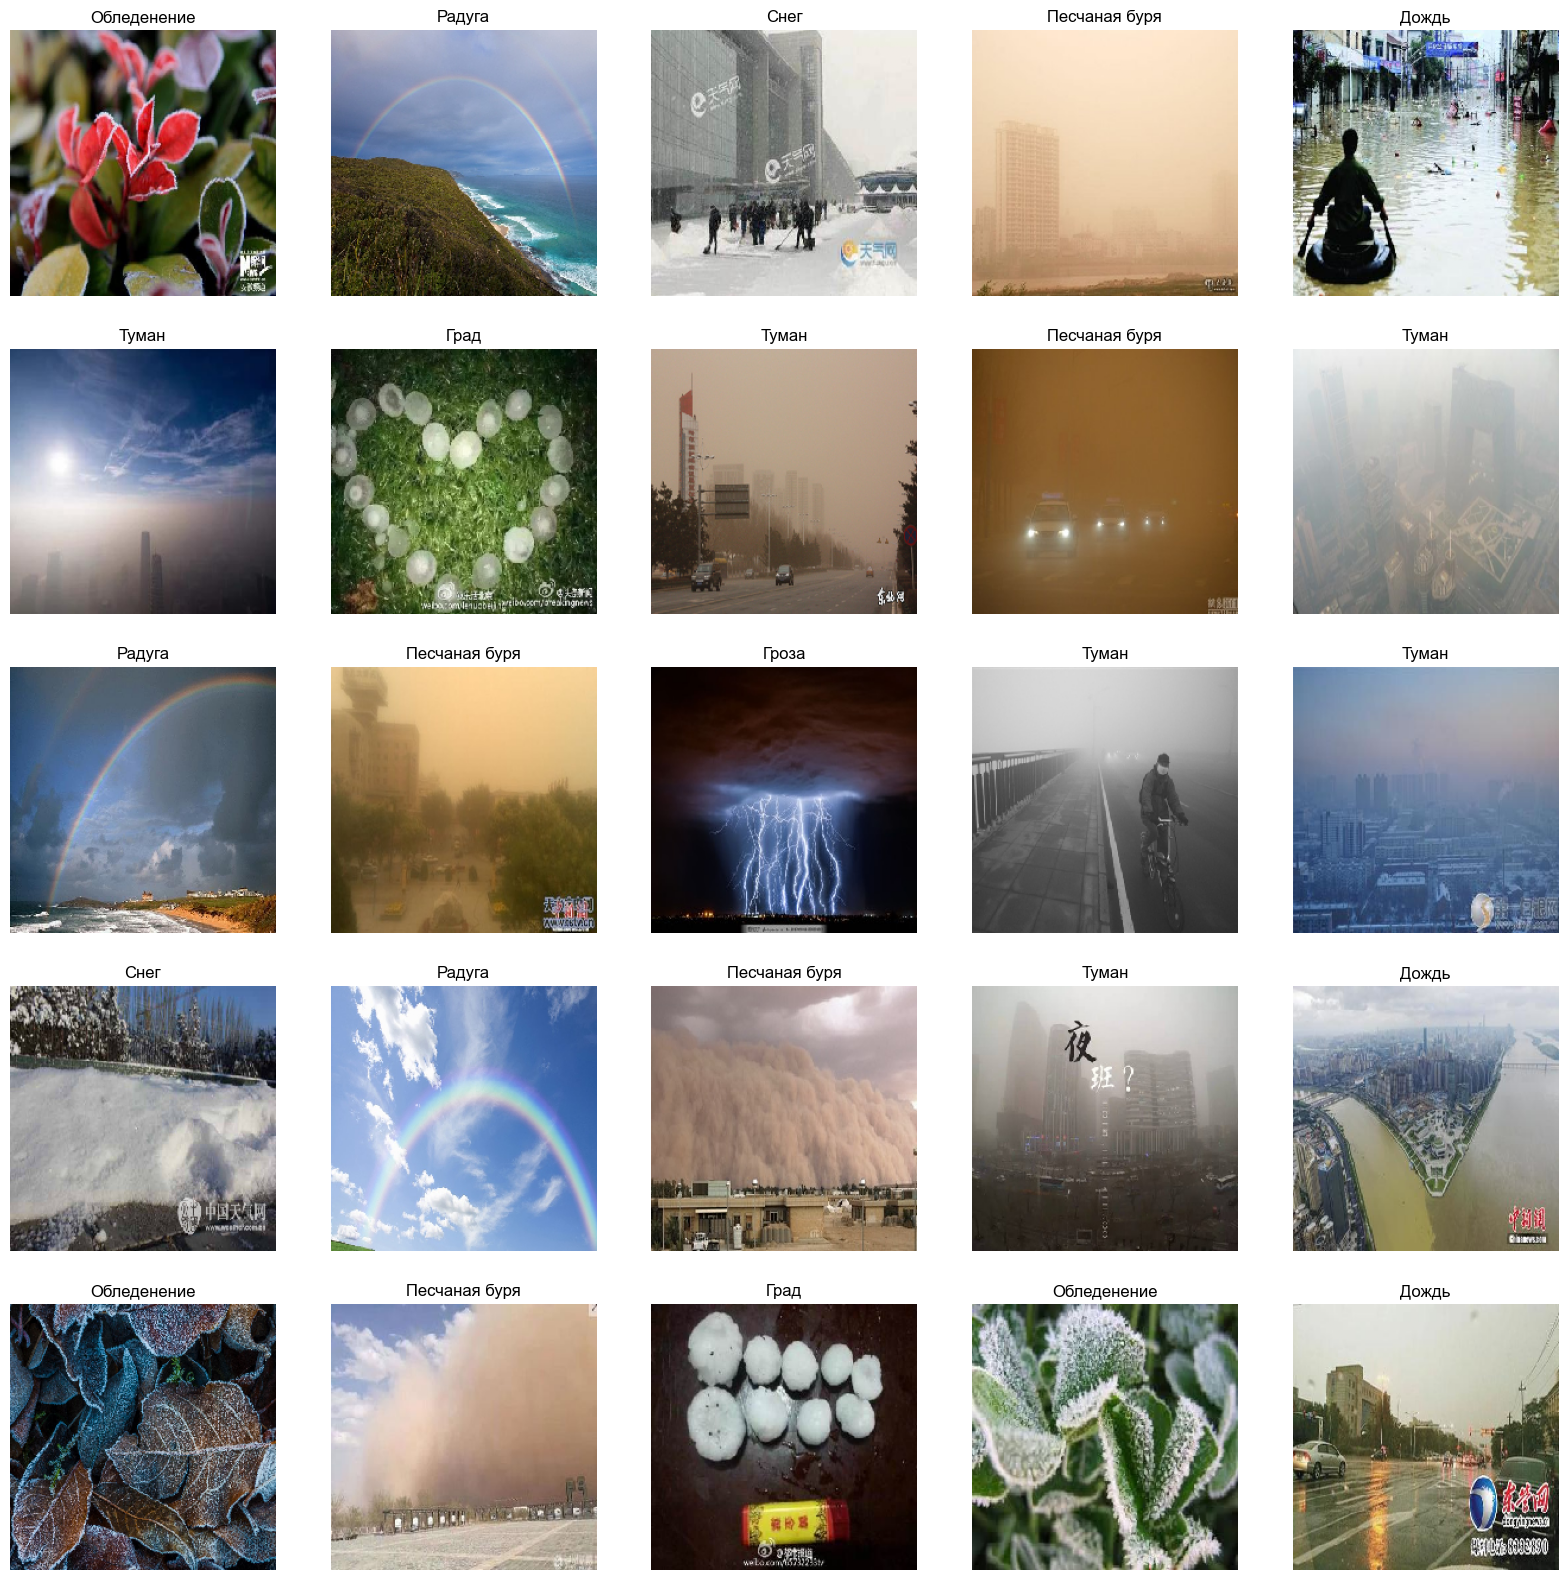

In [32]:
classes = list(train_gen.class_indices.keys())      # лист из названий классов
images, labels = next(train_gen)      # get a batch size samples from the generator

print(classes)


plt.figure(figsize = (20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # индекс картинки
    class_name = classes[index]   # класс картинки
    plt.title(class_name, color = 'black', fontsize = 12)
    plt.axis('off')
plt.show()

Создание универсального модуля

In [8]:
# Создадим структуру модели
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # количество классов

# Создадим предобученную модель
# Будем использовать efficientnetb3 из семейства EfficientNet
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu'),
    Dropout(rate = 0.45, seed = 123),
    Dense(class_count, activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

#model.summary()

NameError: name 'train_gen' is not defined

Тренировочный модуль

In [ ]:
epochs = 20   # количество эпох

# обучение модели
# 
history = model.fit(x = train_gen, epochs = epochs, verbose = 1, validation_data = valid_gen, 
                    validation_steps = None, shuffle = False)

Epoch 1/20
55/55 [==============================] - 602s 10s/step - loss: 7.8136 - accuracy: 0.7494 - val_loss: 6.8298 - val_accuracy: 0.9006
Epoch 2/20
55/55 [==============================] - 525s 10s/step - loss: 5.7313 - accuracy: 0.9416 - val_loss: 5.1189 - val_accuracy: 0.9388
Epoch 3/20
55/55 [==============================] - 485s 9s/step - loss: 4.5018 - accuracy: 0.9737 - val_loss: 4.0712 - val_accuracy: 0.9503
Epoch 4/20
55/55 [==============================] - 485s 9s/step - loss: 3.5900 - accuracy: 0.9805 - val_loss: 3.2611 - val_accuracy: 0.9522
Epoch 5/20
55/55 [==============================] - 485s 9s/step - loss: 2.8725 - accuracy: 0.9857 - val_loss: 2.6273 - val_accuracy: 0.9541
Epoch 6/20
55/55 [==============================] - 484s 9s/step - loss: 2.2984 - accuracy: 0.9928 - val_loss: 2.1453 - val_accuracy: 0.9465
Epoch 7/20
55/55 [==============================] - 484s 9s/step - loss: 1.8467 - accuracy: 0.9914 - val_loss: 1.7303 - val_accuracy: 0.9465
Epoch 8/20


Выведем показатели модуля

In [ ]:
# Define needed variables

# Обучение
# Точность обучения (доля правильных предсказаний)
training_accuracy = history.history['accuracy'] # 
# Доля неправильных предсказаний во время обучения
training_loss = history.history['loss']

# Проверка
# Точность проверок (доля правильных предсказаний)
validation_accuracy = history.history['val_accuracy']
# Доля неправильных предсказаний во время проверки
validation_loss = history.history['val_loss']

index_loss = np.argmin(validation_loss)
val_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_accuracy)
acc_highest = validation_accuracy[index_acc]
Epochs = [i+1 for i in range(len(training_accuracy))]
loss_label = f'Лучшая эпоха: {str(index_loss + 1)}'
acc_label = f'Лучшая эпоха: {str(index_acc + 1)}'
# История обучения
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, training_loss, 'r', label = 'Доля ошибок во время обучения')
plt.plot(Epochs, validation_loss, 'g', label = 'Доля ошибок во время проверки')
plt.scatter(index_loss + 1, val_lowest, s = 150, c = 'blue', label = loss_label)
plt.title('Ошибки обучения и проверки')
plt.xlabel('Эпоха')
plt.ylabel('Ошибки')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, training_accuracy, 'r', label = 'Точность обучения')
plt.plot(Epochs, validation_accuracy, 'g', label = 'Точность проверки')
plt.scatter(index_acc + 1 , acc_highest, s = 150, c = 'blue', label = acc_label)
plt.title('Точность тренировки и проверки')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout
plt.show()

NameError: name 'history' is not defined

Переобучение:
    
    Модель слишком хорошо усваивает обучающие данные до такой степени, что начинает фиксировать шум или случайные колебания данных, а не лежащие в их основе закономерности. В результате переобученная модель становится чрезмерно сложной и теряет способность хорошо обобщать невидимые данные.
    В случае переобучения модель слишком близко подстраивается под обучающие данные (training_loss уменьшается), однако ненадежна в предсказаниях на неизвестных данных (validation_loss увеличивается)

Недообучение:
    
    Модель слишком упрощена, чтобы уловить основные закономерности или отношения в данных.
    В случае недообучения модель демонстрирует высокую предвзятость и делает сильные предположения (training_loss и validation_loss выше оптимальных значений)

В данном случае показатели модели совпадают с оптимальными.

Эффективность модуля

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps = test_steps, verbose = 1)
valid_score = model.evaluate(valid_gen, steps = test_steps, verbose = 1)
test_score = model.evaluate(test_gen, steps = test_steps, verbose = 1)

print("Ошибки в обучении: ", round(train_score[0], ndigits = 3))
print("Точность обучения: ", round(train_score[1], ndigits = 3))
print('-' * 20)
print("Ошибки в проверке: ", round(valid_score[0], ndigits = 3))
print("Точность проверки: ", round(valid_score[1], ndigits = 3))
print('-' * 20)
print("Ошибки в тесте: ", round(test_score[0], ndigits = 3))
print("Точность теста: ", round(test_score[1], ndigits = 3))


5/5 [==============================] - 11s 2s/step - loss: 14.1047 - accuracy: 0.1229
Ошибки в обучении:  14.137
Точность обучения:  0.112
--------------------
Ошибки в проверке:  13.867
Точность проверки:  0.138
--------------------
Ошибки в тесте:  14.105
Точность теста:  0.123


Предсказания

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Матрица ошибок

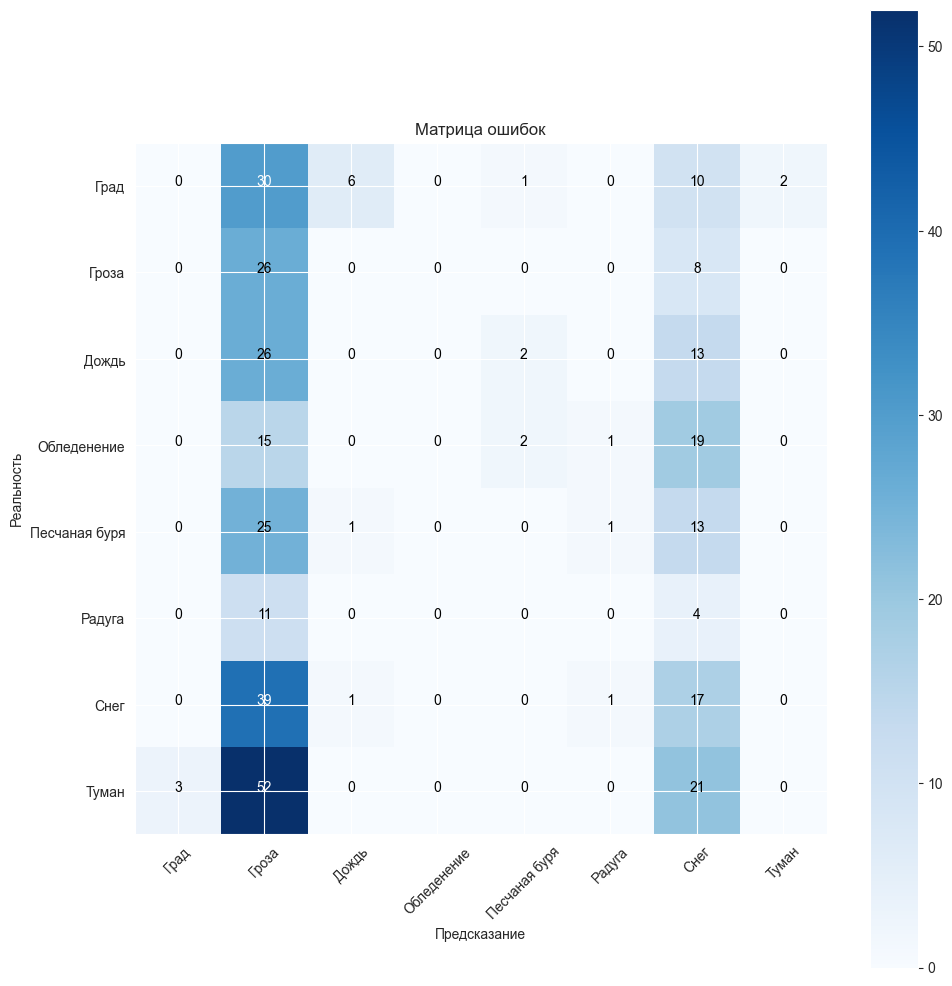

In [ ]:
classes = list(test_gen.class_indices.keys())

# Матрица ошибок
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Матрица ошибок')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Реальность')
plt.xlabel('Предсказание')

plt.show()

Сохраним модель

In [ ]:
# Сохранение модели
model.save('mymodel.h5')

Предсказания с помощью сохраненной модели

In [ ]:
# Загрузка модели
loaded_model = tf.keras.models.load_model('mymodel.h5', compile = False)
loaded_model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Загружаем картинку для предсказания
image_path = 'test.png'
image = Image.open(image_path)

# Подготавливаем картинку
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Делаем предсказание
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])

print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 91ms/step
Дождь
